# Issues

---

## Summary

This notebook does some basic analysis of the issues found in the chosen repositories as well as our topic modeling process.

---

## Set-Up

### Necessary Imports

In [1]:
from collections import Counter
from itertools import chain

In [2]:
from gensim.corpora import Dictionary
from gensim.models import (CoherenceModel,
                           ldamulticore, )
from gensim.utils import simple_preprocess
from pyLDAvis import enable_notebook
from nltk.corpus import stopwords

import pyLDAvis.gensim
import spacy

In [3]:
from matplotlib import rcParams
from scipy.stats import chi2_contingency

import datetime
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Settings

In [4]:
# Turn this off
%pprint
pd.set_option('display.max_columns', None)

plt.style.use('ggplot')
rcParams.update({'figure.autolayout': True})

enable_notebook()

warnings.filterwarnings("ignore")

Pretty printing has been turned OFF


### Globals

In [5]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
STOPS = stopwords.words("english")

# Append the Raft names
STOPS.extend(["tikv", "TiKV", "Tikv", "Hashicorp", "hashicorp", "HashiCorp", "pysyncobj", "PySyncObj", "Pysyncobj"])

In [6]:
# Topic modeling stuff
NUM_TOPICS = 10
PASSES = 4
CHUNK_SIZE = 2_000
SEED = 42
WORKERS = 8

In [7]:
PATH = "issues.csv"
issues = pd.read_csv(PATH)

In [8]:
issues.info()
issues.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5301 entries, 0 to 5300
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID       5301 non-null   int64 
 1   STATUS   5301 non-null   object
 2   ISSUE    5301 non-null   object
 3   LABELS   4148 non-null   object
 4   UPDATED  5301 non-null   object
 5   REPO     5301 non-null   object
dtypes: int64(1), object(5)
memory usage: 248.6+ KB


,ID,STATUS,ISSUE,LABELS,UPDATED,REPO
0,586,OPEN,Leader election times seem too long with max c...,NaN,2024-03-06T10:34:55Z,/hashicorp/
1,585,OPEN,Allow network transfer of snapshot to be cance...,NaN,2024-02-28T20:15:22Z,/hashicorp/
2,578,CLOSED,Inconsistent Raft Latency on Different Infrast...,NaN,2023-10-30T22:10:40Z,/hashicorp/
3,576,CLOSED,Ability for peers to denote others/themselves ...,NaN,2023-10-17T17:25:44Z,/hashicorp/
4,574,CLOSED,Use pebbledb as raft logstore & stablestore; r...,NaN,2023-09-20T03:28:58Z,/hashicorp/


### Functions

In [9]:
def lemmatize(texts: pd.Series, pos: list[str] = ["NOUN", "ADJ", "ADV", "VERB"]) -> list[list[str]]:
    clean = [' '.join(simple_preprocess(text, deacc=True)) for text in texts]
    return [[tok.lemma_ for tok in nlp(doc.lower()) if tok.lemma_ not in STOPS and tok.pos_ in pos] for doc in clean]

In [10]:
lemmatize(pd.Series(["I will Tést thís stuff please!", "He eats with me tomorrow tikv"]), pos=["NOUN", "ADJ", "ADV", "VERB"])

[['test', 'stuff'], ['eat', 'tomorrow']]

---

## Clean-Up

In [11]:
issues.REPO = issues.REPO.map(lambda x: x[1:-1])
issues.REPO

0       hashicorp
1       hashicorp
2       hashicorp
3       hashicorp
4       hashicorp
          ...    
5296        bakwc
5297        bakwc
5298        bakwc
5299        bakwc
5300        bakwc
Name: REPO, Length: 5301, dtype: object

In [12]:
issues.UPDATED = issues.UPDATED.map(lambda x: datetime.datetime.fromisoformat(x).isoformat(timespec="seconds"))
issues.UPDATED

0       2024-03-06T10:34:55+00:00
1       2024-02-28T20:15:22+00:00
2       2023-10-30T22:10:40+00:00
3       2023-10-17T17:25:44+00:00
4       2023-09-20T03:28:58+00:00
                  ...            
5296    2016-07-04T07:52:16+00:00
5297    2016-06-12T03:25:47+00:00
5298    2018-10-28T18:45:28+00:00
5299    2016-04-05T15:15:37+00:00
5300    2016-04-04T09:35:04+00:00
Name: UPDATED, Length: 5301, dtype: object

In [13]:
issues.LABELS = issues.LABELS.fillna(value="").map(lambda x: x.strip().lower().split('; '))
issues.LABELS

0       []
1       []
2       []
3       []
4       []
        ..
5296    []
5297    []
5298    []
5299    []
5300    []
Name: LABELS, Length: 5301, dtype: object

In [14]:
issues['COUNT'] = issues.LABELS.map(lambda x: len(x) if x != [''] else 0)
issues.COUNT

0       0
1       0
2       0
3       0
4       0
       ..
5296    0
5297    0
5298    0
5299    0
5300    0
Name: COUNT, Length: 5301, dtype: int64

---

## Exploration

<Axes: xlabel='REPO', ylabel='count'>

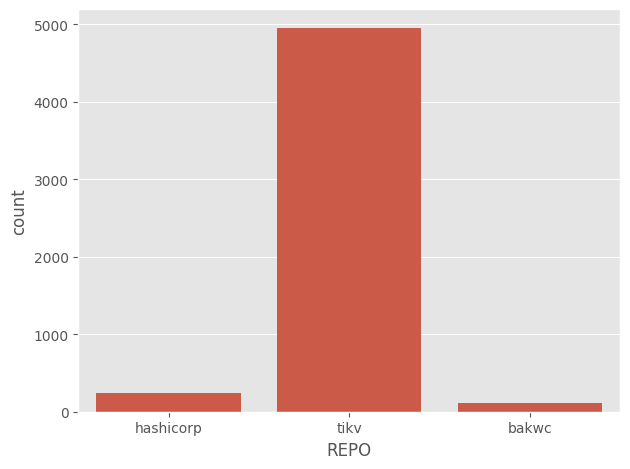

In [15]:
sns.countplot(data=issues, x='REPO')

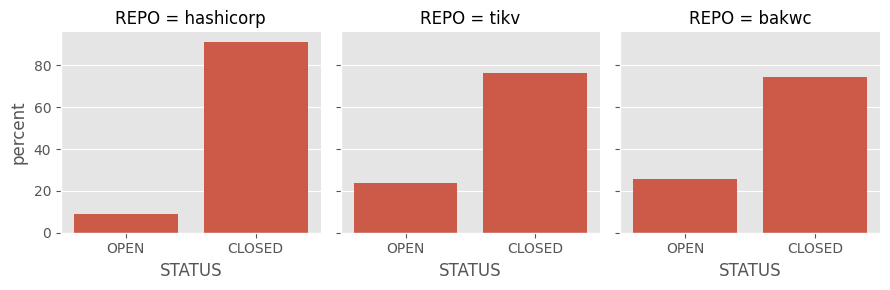

In [16]:
sns.FacetGrid(data=issues, col='REPO').map_dataframe(sns.countplot, x='STATUS', stat='percent')


In [17]:
issues.groupby(["REPO"]).STATUS.value_counts()

REPO       STATUS
bakwc      CLOSED      81
           OPEN        28
hashicorp  CLOSED     219
           OPEN        21
tikv       CLOSED    3778
           OPEN      1174
Name: count, dtype: int64

In [18]:
# Statistical test
table = issues.groupby(["REPO"]).STATUS.value_counts().to_numpy().reshape(3,2).T
table

array([[  81,  219, 3778],
       [  28,   21, 1174]])

- H_0: There is no difference between repos on the number of closed and open issues

In [19]:
chi2_contingency(table)

Chi2ContingencyResult(statistic=29.284518857026885, pvalue=4.374692459839192e-07, dof=2, expected_freq=array([[  83.85248066,  184.62931522, 3809.51820411],
       [  25.14751934,   55.37068478, 1142.48179589]]))

There is a statistically significant difference between closed and open issues based on GitHub repository

In [20]:
issues.ISSUE[:4].to_list()

['Leader election times seem too long with max current term', 'Allow network transfer of snapshot to be cancelled during shutdown', 'Inconsistent Raft Latency on Different Infrastructures', 'Ability for peers to denote others/themselves as too laggy to accept requests']

In [21]:
issues["LEN"] = issues.ISSUE.map(lambda x: len(simple_preprocess(x)))

<Axes: xlabel='LEN', ylabel='Density'>

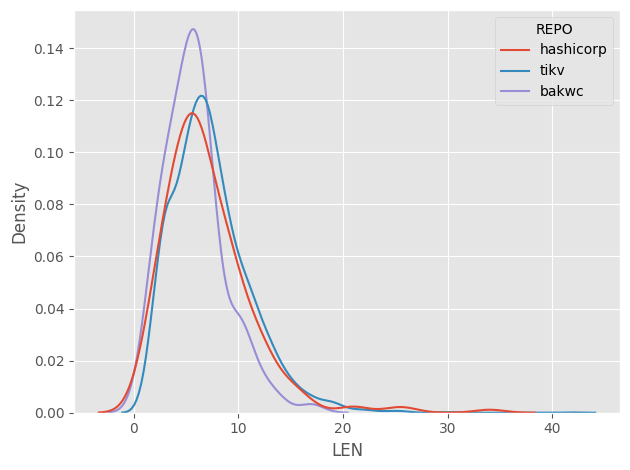

In [22]:
sns.kdeplot(data=issues, x="LEN", hue="REPO", common_norm=False)

In [23]:
counts = Counter(chain(*issues.LABELS.to_list()))
counts.total()

all_counts = {repo: Counter(chain(*issues[(issues.REPO == repo) & (issues.COUNT != 0)].LABELS.to_list())) for repo in issues.REPO.unique()}

In [24]:
print(f"Total tags: {len(counts)}")
for repo in all_counts:
    print(f"{repo.upper()} total: {len(all_counts[repo])}")

Total tags: 130
HASHICORP total: 10
TIKV total: 118
BAKWC total: 4


[Text(0, 0, 'type/bug'), Text(1, 0, ''), Text(2, 0, 'type/enhancement'), Text(3, 0, 'severity/major'), Text(4, 0, 'component/test-bench'), Text(5, 0, 'difficulty/easy'), Text(6, 0, 'sig/coprocessor'), Text(7, 0, 'help wanted'), Text(8, 0, 'sig/raft'), Text(9, 0, 'affects-7.1')]

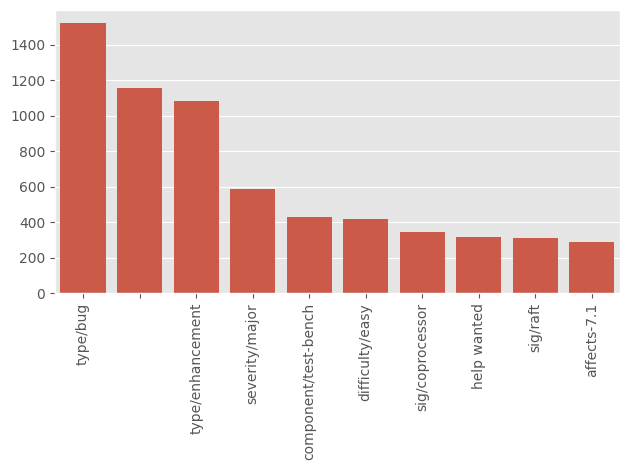

In [25]:
top = dict(counts.most_common(10))
sns.barplot(data=top).set_xticklabels(top, rotation=90)

In [26]:
for repo in all_counts:

    top = dict(all_counts[repo].most_common(10))
    ax = sns.barplot(data=top)
    ax.set_xticklabels(top, rotation=90)
    ax.set_title(repo)
    plt.savefig(f"figures/{repo}.png")
    plt.close()

In [27]:
most_pop_tops = {label for repo in all_counts for label, count in all_counts[repo].most_common(10)}
most_pop_tops

{'flaky-test', 'docs', 'component/test-bench', 'performance', 'severity/major', 'good-first-issue', 'thinking', 'difficulty/easy', 'sig/coprocessor', 'enhancement', 'question', 'type/enhancement', 'type/bug', 'sig/raft', 'hacktoberfest', 'help wanted', 'severity/moderate', 'waiting-reply', 'good first issue', 'affects-7.1', 'bug'}

In [45]:
bugs = {label for label in most_pop_tops if "bug" in label}
bugs

{'bug', 'type/bug'}

---

## GitHub Issue Topic Modeling

The way we approach this is as follows:
1. Take all entries which have at least one of the ten (or all) most popular `LABELS` for that given repository.
2. Preprocess the `ISSUE` header and convert to lemma form, removing stop words.
2. Perform LDA topic modeling with all entries from step 1a nd compute the coherence score.
4. Perform basic LDA topic modeling and compute the coherence score per repository.
5. Perform only on bugs for bug topic modeling.

In [48]:
# 1
def has_top(x: list):
    return most_pop_tops.difference(set(x)) != most_pop_tops

def has_bug(x: list):
    return bugs.difference(set(x)) != bugs


issues['HAS_TOP'] = issues.LABELS.map(has_top)
issues.HAS_TOP

0       False
1       False
2       False
3       False
4       False
        ...  
5296    False
5297    False
5298    False
5299    False
5300    False
Name: HAS_TOP, Length: 5301, dtype: bool

In [49]:
issues['HAS_BUG'] = issues.LABELS.map(has_bug)
issues.HAS_BUG

0       False
1       False
2       False
3       False
4       False
        ...  
5296    False
5297    False
5298    False
5299    False
5300    False
Name: HAS_BUG, Length: 5301, dtype: bool

In [29]:
len(issues[issues.HAS_TOP])

3569

In [30]:
# Count word appearances and map types (words) to an index : (ind, count in document)
# 2.
lemmas = lemmatize(issues[issues.HAS_TOP].ISSUE)
d = Dictionary(lemmas)

In [31]:
# Sanity check to make sure there are no stop words
for sent in lemmas:
    for word in sent:
        if word in STOPS:
            print(sent, word)
            break

In [32]:
Id = 1501
print(lemmas[Id])
print(d.doc2bow(lemmas[Id]))

['slow', 'handle', 'raft', 'message', 'obvious', 'latency', 'source']
[(17, 1), (284, 1), (313, 1), (423, 1), (622, 1), (959, 1), (1583, 1)]


In [33]:
# Transform into a bag of words for each document
corpus = [d.doc2bow(issue) for issue in lemmas]

In [34]:
corpus[Id]

[(17, 1), (284, 1), (313, 1), (423, 1), (622, 1), (959, 1), (1583, 1)]

In [35]:
# How to get the word back
wid = corpus[Id][1][0]
d[wid]

'message'

In [36]:
# 3.
model = ldamulticore.LdaMulticore(corpus=corpus, id2word=d, num_topics=NUM_TOPICS,
                                  chunksize=CHUNK_SIZE, passes=PASSES, 
                                  per_word_topics=True, random_state=SEED, workers=WORKERS)

In [37]:
# Get the coherence score
coh_model = CoherenceModel(model=model, texts=lemmas, corpus=corpus, dictionary=d, coherence='c_v')
print(coh_model.get_coherence(), coh_model.get_coherence_per_topic())

0.3759455226221599 [0.38001850859769243, 0.3605425205407113, 0.27328036307431214, 0.5271584042964752, 0.5698802046404674, 0.26432717343348966, 0.35068020332023925, 0.394878199742795, 0.3412223314734356, 0.29746731710198177]


In [38]:
# Visualize
# Learned about this library from https://github.com/wjbmattingly/topic_modeling_textbook/blob/main/03_03_lda_model_demo.ipynb
pyLDAvis.gensim.prepare(model, corpus, d, mds="mmds", R=NUM_TOPICS)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.207647  0.001776       1        1  14.141397
6      0.065466  0.110479       2        1  11.775332
2     -0.152592  0.130678       3        1  11.084829
8      0.045118 -0.054501       4        1   9.999332
4      0.279781 -0.124785       5        1   9.907917
3      0.185367  0.158016       6        1   9.385734
9     -0.033195  0.167434       7        1   9.377799
0      0.025158 -0.187174       8        1   9.179466
1     -0.099129 -0.031477       9        1   7.809278
7     -0.108328 -0.170447      10        1   7.338917, topic_info=          Term        Freq       Total Category  logprob  loglift
68        fail  493.000000  493.000000  Default  10.0000  10.0000
1718   migrate  189.000000  189.000000  Default   9.0000   9.0000
1996    scalar  188.000000  188.000000  Default   8.0000   8.0000
1955       ucp  194.000000  194.000000  Default   7.0000   7.0000
657   function  210.000000  210.000000  Default   6.0000   6.0000
...        ...         ...         ...      ...      ...      ...
91      memory   15.589722   83.694156  Topic10  -4.4136   0.9314
83       panic   20.286237  180.721631  Topic10  -4.1503   0.4250
29         log   19.374172  192.774240  Topic10  -4.1963   0.3144
68        fail   27.468493  493.724061  Topic10  -3.8472  -0.2770
85         use   14.397403  126.671348  Topic10  -4.4932   0.4374

[257 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2405      8  0.731258    ability
968       7  0.759501  accompany
45        1  0.039109        add
45        2  0.068440        add
45        3  0.195544        add
...     ...       ...        ...
272       6  0.031409      write
272       7  0.015704      write
272       8  0.015704      write
272       9  0.047113      write
272      10  0.047113      write

[834 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 3, 9, 5, 4, 10, 1, 2, 8])

In [39]:
# 4.
models = {repo: [] for repo in all_counts}

for repo in all_counts:

    sublemmas = lemmatize(issues[(issues.HAS_TOP) & (issues.REPO == repo)].ISSUE)
    subdict = Dictionary(sublemmas)
    subcorpus = [subdict.doc2bow(text) for text in sublemmas]

    submodel = ldamulticore.LdaMulticore(corpus=subcorpus, id2word=subdict, num_topics=NUM_TOPICS if repo != "bakwc" else 4,
                                             chunksize=CHUNK_SIZE, passes=PASSES, 
                                             per_word_topics=True, random_state=SEED, workers=WORKERS)
    coh_model = CoherenceModel(model=submodel, texts=sublemmas, corpus=subcorpus, dictionary=subdict, coherence='c_v')
    
    print(f"Coherence for {repo}: {coh_model.get_coherence()} | {coh_model.get_coherence_per_topic()}")
    models[repo].extend([submodel, subcorpus, subdict])

Coherence for hashicorp: 0.47543295325285584 | [0.4232109950524701, 0.4079582060562531, 0.4025699898624079, 0.48778219082371077, 0.5227325230365081, 0.46273784222758413, 0.5282582937331826, 0.5132158326976054, 0.5016783349681275, 0.5041853240707087]
Coherence for tikv: 0.35561246785801515 | [0.2451357196694845, 0.27457256018675213, 0.4741978056193747, 0.4965898363861182, 0.3464361951265469, 0.39003389707050207, 0.4419036586961254, 0.25400964867288467, 0.3752688762162428, 0.2579764809361206]
Coherence for bakwc: 0.5001795471065502 | [0.4287973395919481, 0.4634431647526015, 0.5685873410709189, 0.5398903430107322]


In [40]:
pyLDAvis.gensim.prepare(*models["hashicorp"], mds="mmds", R=NUM_TOPICS)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.197501 -0.021657       1        1  15.481251
4      0.119991  0.178635       2        1  14.277970
8     -0.151026 -0.142799       3        1  11.997412
3     -0.166350  0.087290       4        1  10.159716
6      0.089366 -0.174213       5        1   9.073024
7     -0.054814  0.160130       6        1   8.614281
0     -0.023656 -0.130067       7        1   8.528605
9     -0.115071 -0.021227       8        1   8.207439
5      0.045706  0.086666       9        1   7.949773
1      0.058352 -0.022759      10        1   5.710528, topic_info=         Term      Freq     Total Category  logprob  loglift
29        log  7.000000  7.000000  Default  10.0000  10.0000
121  snapshot  5.000000  5.000000  Default   9.0000   9.0000
211       old  3.000000  3.000000  Default   8.0000   8.0000
112      test  4.000000  4.000000  Default   7.0000   7.0000
26      apply  3.000000  3.000000  Default   6.0000   6.0000
..        ...       ...       ...      ...      ...      ...
103       get  0.588705  3.731931  Topic10  -3.8449   1.0161
234       mix  0.588705  1.810289  Topic10  -3.8449   1.7395
235       new  0.588705  1.841527  Topic10  -3.8449   1.7224
169    config  0.588703  1.841524  Topic10  -3.8449   1.7224
83      panic  0.588703  1.856151  Topic10  -3.8449   1.7145

[191 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
25        7  0.813323     able
163       9  0.839364   access
45        1  0.501873      add
45        2  0.167291      add
45        3  0.167291      add
...     ...       ...      ...
42        3  0.386821     vote
42        7  0.386821     vote
80        8  0.827800  warning
168       3  0.541632   window
168       9  0.541632   window

[260 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 9, 4, 7, 8, 1, 10, 6, 2])

In [41]:
pyLDAvis.gensim.prepare(*models["tikv"], mds="mmds", R=NUM_TOPICS)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.032025  0.009838       1        1  13.176912
1     -0.012493 -0.156198       2        1  12.590536
0     -0.202888 -0.048807       3        1  10.975287
6     -0.127010  0.227233       4        1  10.853010
2      0.282461 -0.189501       5        1  10.783653
8      0.125670 -0.047958       6        1   9.648873
5      0.010105  0.172741       7        1   8.897115
4     -0.109206 -0.146976       8        1   8.500621
9     -0.143878  0.051912       9        1   8.420759
3      0.145214  0.127717      10        1   6.153236, topic_info=          Term        Freq       Total Category  logprob  loglift
1         fail  468.000000  468.000000  Default  10.0000  10.0000
482   function  196.000000  196.000000  Default   9.0000   9.0000
1869       ucp  181.000000  181.000000  Default   8.0000   8.0000
381       tidb  203.000000  203.000000  Default   7.0000   7.0000
1623   migrate  177.000000  177.000000  Default   6.0000   6.0000
...        ...         ...         ...      ...      ...      ...
52       apply   10.802125   54.924020  Topic10  -4.5694   1.1620
36        test   17.758567  239.952684  Topic10  -4.0723   0.1846
10     version    7.435324   41.734936  Topic10  -4.9429   1.0631
54         log   10.684765  184.243623  Topic10  -4.5804  -0.0592
1         fail    8.334511  468.410760  Topic10  -4.8288  -1.2407

[250 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1017      6  0.165151  accept
1017      7  0.660602  accept
625       2  0.122692   alert
625       6  0.122692   alert
625       9  0.613458   alert
...     ...       ...     ...
71        4  0.032128   write
71        5  0.048192   write
71        6  0.546181   write
71        9  0.032128   write
71       10  0.032128   write

[842 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 1, 7, 3, 9, 6, 5, 10, 4])

In [42]:
pyLDAvis.gensim.prepare(*models["bakwc"], mds="mmds", R=NUM_TOPICS)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.093722 -0.090778       1        1  31.231176
1     -0.041118  0.125700       2        1  30.008029
2      0.074385 -0.076170       3        1  20.475053
3      0.060455  0.041248       4        1  18.285742, topic_info=        Term      Freq     Total Category  logprob  loglift
41   dynamic  2.000000  2.000000  Default  10.0000  10.0000
33    change  2.000000  2.000000  Default   9.0000   9.0000
30      node  3.000000  3.000000  Default   8.0000   8.0000
63   command  1.000000  1.000000  Default   7.0000   7.0000
31  topology  1.000000  1.000000  Default   6.0000   6.0000
..       ...       ...       ...      ...      ...      ...
38       add  1.185824  4.611445   Topic4  -2.9096   0.3409
30      node  0.657051  3.466944   Topic4  -3.5001   0.0358
61   ability  0.656033  1.721974   Topic4  -3.5016   0.7340
28   cluster  0.655220  2.941696   Topic4  -3.5029   0.1973
63   command  0.654379  1.634221   Topic4  -3.5041   0.7838

[65 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
61        1  0.580729      ability
61        4  0.580729      ability
76        3  0.900665       accept
38        1  0.216852          add
38        2  0.433704          add
...     ...       ...          ...
58        4  0.911023  transaction
83        4  0.911018        usage
4         1  0.423653          use
4         3  0.423653          use
32        4  0.911032         view

[66 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

In [58]:
# 5.
bug_models = {repo: [] for repo in all_counts}

for repo in all_counts:

    sublemmas = lemmatize(issues[(issues.HAS_BUG) & (issues.REPO == repo)].ISSUE)
    subdict = Dictionary(sublemmas)
    subcorpus = [subdict.doc2bow(text) for text in sublemmas]

    submodel = ldamulticore.LdaMulticore(corpus=subcorpus, id2word=subdict, num_topics=NUM_TOPICS,
                                             chunksize=CHUNK_SIZE, passes=PASSES, 
                                             per_word_topics=True, random_state=SEED, workers=WORKERS)
    coh_model = CoherenceModel(model=submodel, texts=sublemmas, corpus=subcorpus, dictionary=subdict, coherence='c_v')
    
    print(f"Coherence for {repo}: {coh_model.get_coherence()} | {coh_model.get_coherence_per_topic()}")
    bug_models[repo].extend([submodel, subcorpus, subdict])

Coherence for hashicorp: 0.5931855724695811 | [0.7052464422570311, 0.6513655262586996, 0.6731245668798203, 0.526201191175311, 0.6450219200791413, 0.41867518717854635, 0.7082709858227169, 0.44557759154358745, 0.45181224696995254, 0.7065600665310058]
Coherence for tikv: 0.4051967405875813 | [0.43214341460414313, 0.32453533928948924, 0.39249470012129206, 0.4974812773549776, 0.350926260069852, 0.3336152855562591, 0.3473673119638553, 0.4857096676104497, 0.3838975561512838, 0.5037965931542111]
Coherence for bakwc: 0.6901590746994584 | [0.6952889309458146, 0.6982921401298243, 0.6982921401298244, 0.6897437732041091, 0.6684518222399427, 0.6982921401298244, 0.7099416056122805, 0.7099416056122804, 0.7036460880309943, 0.6297005009596901]


In [59]:
pyLDAvis.gensim.prepare(*bug_models["hashicorp"], mds="mmds", R=8)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.172099 -0.061314       1        1  20.403650
5     -0.102996 -0.156600       2        1  19.596263
7     -0.118663  0.175910       3        1  17.083381
3      0.087524 -0.145226       4        1  13.064924
1      0.178401 -0.030149       5        1  12.254152
2      0.110974  0.106380       6        1   7.118161
4      0.004367  0.096919       7        1   5.808646
0      0.004168  0.004691       8        1   1.556941
6      0.004162  0.004694       9        1   1.556941
9      0.004162  0.004694      10        1   1.556941, topic_info=            Term      Freq     Total Category  logprob  loglift
19      snapshot  3.000000  3.000000  Default   8.0000   8.0000
10          raft  2.000000  2.000000  Default   7.0000   7.0000
27         fuzzy  1.000000  1.000000  Default   6.0000   6.0000
6   indefinitely  1.000000  1.000000  Default   5.0000   5.0000
5           hang  1.000000  1.000000  Default   4.0000   4.0000
..           ...       ...       ...      ...      ...      ...
73      unstable  0.020619  1.070340  Topic10  -4.3041   0.2129
19      snapshot  0.020619  3.940950  Topic10  -4.3041  -1.0905
10          raft  0.020619  2.225165  Topic10  -4.3041  -0.5189
71       restore  0.020619  1.859264  Topic10  -4.3041  -0.3393
62           get  0.020619  2.557999  Topic10  -4.3041  -0.6583

[131 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
46        1  0.843362        access
42        7  1.063003           api
33        6  1.025114  appendentrie
20        4  0.925957   arbitrarily
14        2  0.865652       attempt
...     ...       ...           ...
26        1  0.406907           use
26        2  0.406907           use
26        4  0.406907           use
52        1  0.537847        window
52        2  0.537847        window

[79 rows x 3 columns], R=8, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 8, 4, 2, 3, 5, 1, 7, 10])

In [60]:
pyLDAvis.gensim.prepare(*bug_models["tikv"], mds="mmds", R=8)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.204846  0.036767       1        1  15.419182
1     -0.026571  0.078838       2        1  13.754746
6     -0.123855  0.165136       3        1  12.455250
5      0.077310 -0.019237       4        1  10.628305
4      0.186440 -0.065230       5        1   9.922727
7      0.189024  0.109258       6        1   8.677852
0      0.037915  0.181439       7        1   8.135415
3      0.041620 -0.215589       8        1   7.863694
8     -0.153300 -0.150032       9        1   6.720652
9     -0.023736 -0.121348      10        1   6.422178, topic_info=           Term        Freq       Total Category  logprob  loglift
30         test  108.000000  108.000000  Default   8.0000   8.0000
209      region  248.000000  248.000000  Default   7.0000   7.0000
452     dynamic  150.000000  150.000000  Default   6.0000   6.0000
1          fail  217.000000  217.000000  Default   5.0000   5.0000
347  compaction   25.000000   25.000000  Default   4.0000   4.0000
..          ...         ...         ...      ...      ...      ...
109       index    5.501501   20.563699  Topic10  -4.5662   1.4269
1          fail   11.228651  217.411866  Topic10  -3.8528  -0.2179
285      report    4.899755   26.526301  Topic10  -4.6820   1.0565
117       write    4.900336   35.072615  Topic10  -4.6819   0.7773
209      region    5.066680  248.226088  Topic10  -4.6485  -1.1462

[204 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
100       7  0.794922  alpha
185       2  0.106502    api
185       5  0.639012    api
185      10  0.106502    api
32        1  0.329219  apply
...     ...       ...    ...
117       6  0.028512  write
117       7  0.028512  write
117       8  0.085537  write
117       9  0.171074  write
117      10  0.142561  write

[607 rows x 3 columns], R=8, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 7, 6, 5, 8, 1, 4, 9, 10])

In [61]:
view = pyLDAvis.gensim.prepare(*bug_models["bakwc"], mds="mmds", R=8)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.188957 -0.033071       1        1  22.423330
3      0.092792  0.215345       2        1  20.042391
8     -0.173542 -0.074081       3        1  15.367572
4     -0.157433  0.056182       4        1  12.237535
2      0.065589 -0.166498       5        1  10.814757
1     -0.023898  0.094163       6        1   7.562719
7     -0.012683 -0.078033       7        1   5.326947
0      0.006739 -0.004669       8        1   2.074916
5      0.006739 -0.004669       9        1   2.074916
6      0.006740 -0.004669      10        1   2.074916, topic_info=         Term      Freq     Total Category  logprob  loglift
6       index  0.000000  0.000000  Default   8.0000   8.0000
7   monotonic  0.000000  0.000000  Default   7.0000   7.0000
19  iteration  1.000000  1.000000  Default   6.0000   6.0000
22       size  1.000000  1.000000  Default   5.0000   5.0000
18     change  1.000000  1.000000  Default   4.0000   4.0000
..        ...       ...       ...      ...      ...      ...
12    restart  0.024306  0.987025  Topic10  -3.5553   0.1713
30       tick  0.024306  0.987025  Topic10  -3.5553   0.1713
22       size  0.024306  1.780153  Topic10  -3.5553  -0.4185
18     change  0.024306  1.780152  Topic10  -3.5553  -0.4185
10  typeerror  0.024306  1.065439  Topic10  -3.5553   0.0948

[111 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
28        3  0.938580           add
8         3  0.938580       address
11        5  1.013145         appye
18        2  0.561750        change
24        1  0.872314         check
13        3  0.603967       cluster
13        4  0.603967       cluster
0         1  0.872314        commit
25        1  0.872314     corrupted
32        6  1.061116           cpu
14        4  0.947283     different
26        1  0.872314          dump
1         1  0.872314         entry
23        2  0.890661     exception
19        2  0.561749     iteration
2         1  0.872314        leader
3         1  0.599510           log
3         5  0.599510           log
15        3  0.603967          node
15        4  0.603967          node
4         1  0.872314           old
33        6  1.061116        python
9         3  0.938580       resolve
12        5  1.013146       restart
20        2  0.890661  runtimeerror
21        2  0.890661           set
29        3  0.938580        single
22        2  0.561749          size
5         1  0.872314          term
30        5  1.013146          tick
16        4  0.947283      topology
31        5  1.013146     traceback
10        3  0.938580     typeerror
34        6  1.061116         usage
17        4  0.947283          view, R=8, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 4, 9, 5, 3, 2, 8, 1, 6, 7])